In [1]:
import torch
import pickle
import numpy as np
from argparse import Namespace
from torch.utils.data import DataLoader
import torch.nn.functional as F
from heterogt.utils.tokenizer import EHRTokenizer
from heterogt.utils.dataset import FineTuneEHRDataset, batcher, expand_level3
from heterogt.utils.train import PHENO_ORDER
from heterogt.utils.seed import set_random_seed
from heterogt.utils.model_attn_vis import SampleVis
from heterogt.model.model_vis import HeteroGTFineTuneVis

Disabling PyTorch because PyTorch >= 2.1 is required but found 1.13.1
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
set_random_seed(123)

[INFO] Random seed set to 123


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
config = Namespace(
    dataset = "MIMIC-IV",
    tasks = ["death", "readmission", "stay", "next_diag_12m"],
    task_index = 3,  # index of the task to train
    token_type = ["diag", "med", "lab", "pro"],
    special_tokens = ["[PAD]", "[CLS]"],
    # only for tf layer
    attn_mask_dicts = [{1:[6,7], 2:[6,7], 3:[6,7], 4:[6,7], 5:[6,7], 6:[1,2,3,4,5,6,7], 7:[1,2,3,4,5,6,7]}, 
                       {1:[6,7], 2:[6,7], 3:[6,7], 4:[6,7], 5:[6,7], 6:[1,2,3,4,5,6,7], 7:[1,2,3,4,5,6,7]}], 
    d_model = 64,
    num_heads = 4,
    batch_size = 32,
    lr = 1e-3,
    epochs = 500,
    early_stop_patience = 10,
    group_code_thre = 5,  # if there are group_code_thre diag codes belongs to the same group ICD code, then the group code is generated
    use_pretrained_model = True,
    pretrain_mask_rate = 0.7,
    pretrain_cls_ontology_weight = 5e-2,
    pretrain_visit_ontology_weight = 5e-2,
    pretrain_adm_type_weight = 0,
    dec_loss_lambda = 1e-2,
)

In [5]:
full_data_path = f"./data_process/{config.dataset}-processed/mimic.pkl"  # for tokenizer
curr_task = config.tasks[config.task_index]
print("Current task:", curr_task)
if curr_task == "next_diag_6m":
    finetune_data_path = f"./data_process/{config.dataset}-processed/mimic_nextdiag_6m.pkl"
elif curr_task == "next_diag_12m":
    finetune_data_path = f"./data_process/{config.dataset}-processed/mimic_nextdiag_12m.pkl"
else:
    finetune_data_path = f"./data_process/{config.dataset}-processed/mimic_downstream.pkl"

Current task: next_diag_12m


In [6]:
ehr_full_data = pickle.load(open(full_data_path, 'rb'))
group_code_sentences = [expand_level3()[1]]
diag_sentences = ehr_full_data["ICD9_CODE"].values.tolist()
med_sentences = ehr_full_data["NDC"].values.tolist()
lab_sentences = ehr_full_data["LAB_TEST"].values.tolist()
pro_sentences = ehr_full_data["PRO_CODE"].values.tolist()
age_sentences = [[str(c)] for c in set(ehr_full_data["AGE"].values.tolist())] # important of [[]]
adm_type_sentences = ehr_full_data["ADMISSION_TYPE"].values.tolist()
max_admissions = ehr_full_data.groupby("SUBJECT_ID")["HADM_ID"].nunique().max()
config.max_num_adms = max_admissions
print(f"Max admissions per patient: {config.max_num_adms}")

Max admissions per patient: 8


In [7]:
tokenizer = EHRTokenizer(age_sentences, group_code_sentences, diag_sentences, med_sentences, lab_sentences, 
                         pro_sentences, special_tokens=config.special_tokens, adm_types_sentences=adm_type_sentences)
config.label_vocab_size = len(PHENO_ORDER)  # a set of predifined diseases
config.global_vocab_size = len(tokenizer.vocab.id2word)
config.age_vocab_size = tokenizer.token_number("age")
config.group_code_vocab_size = tokenizer.token_number("group")
print(f"Age vocabulary size: {config.age_vocab_size}")
print(f"Group code vocabulary size: {config.group_code_vocab_size}")

Age vocabulary size: 20
Group code vocabulary size: 19


In [8]:
train_data, val_data, test_data = pickle.load(open(finetune_data_path, 'rb'))
# example label percentage
print("Percentage of DEATH in test dataset:",
      (test_data["DEATH"] == True).mean() * 100, "%")

print("Percentage of READMISSION in test dataset:",
      (test_data["READMISSION"] == 1).mean() * 100, "%")

print("Percentage of STAY>7 days in test dataset:",
      (test_data["STAY_DAYS"] > 7).mean() * 100, "%")

Percentage of DEATH in test dataset: 3.327211839688884 %
Percentage of READMISSION in test dataset: 79.05368910014043 %
Percentage of STAY>7 days in test dataset: 34.87090850167441 %


In [9]:
train_dataset = FineTuneEHRDataset(train_data, tokenizer, token_type=config.token_type, task=curr_task, 
                                   max_num_adms=config.max_num_adms, group_code_thre=config.group_code_thre)
val_dataset = FineTuneEHRDataset(val_data, tokenizer, token_type=config.token_type, task=curr_task, 
                                 max_num_adms=config.max_num_adms, group_code_thre=config.group_code_thre)
test_dataset = FineTuneEHRDataset(test_data, tokenizer, token_type=config.token_type, task=curr_task, 
                                   max_num_adms=config.max_num_adms, group_code_thre=config.group_code_thre)

In [10]:
long_adm_seq_crite = 3
val_long_seq_idx, test_long_seq_idx = [], []
for i in range(len(val_dataset)):
    hadm_id = list(val_dataset.records.keys())[i]
    num_adms = len(val_dataset.records[hadm_id])
    if num_adms >= long_adm_seq_crite:
        val_long_seq_idx.append(i)
for i in range(len(test_dataset)):
    hadm_id = list(test_dataset.records.keys())[i]
    num_adms = len(test_dataset.records[hadm_id])
    if num_adms >= long_adm_seq_crite:
        test_long_seq_idx.append(i)
print(len(val_long_seq_idx), len(test_long_seq_idx))

857 876


In [11]:
num_group_code = []
for i in range(len(train_dataset)):
    input_ids, token_types, adm_index, age_ids, diag_group_codes, labels = train_dataset[i]
    count = (token_types[0] == 6).sum().item()
    num_group_code.append(count)
print("Mean group token numer per patient", np.mean(num_group_code))

Mean group token numer per patient 0.874014598540146


In [12]:
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=batcher(tokenizer, n_token_type=len(config.token_type), is_pretrain = False),
    shuffle=True,
    batch_size=config.batch_size,
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=batcher(tokenizer, n_token_type=len(config.token_type), is_pretrain = False),
    shuffle=False,
    batch_size=config.batch_size,
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=batcher(tokenizer, n_token_type=len(config.token_type), is_pretrain = False),
    shuffle=False,
    batch_size=config.batch_size,
)

In [13]:
for batch in train_dataloader:
    pass  # just to check if the dataloader works
for batch in val_dataloader:
    pass  # just to check if the dataloader works
for batch in test_dataloader:
    pass  # just to check if the dataloader works
print("All pass!")

All pass!


In [14]:
if curr_task in ["death", "stay", "readmission"]:
    eval_metric = "f1"
    task_type = "binary"
    loss_fn = F.binary_cross_entropy_with_logits
else:
    eval_metric = "f1"
    task_type = "l2r"
    loss_fn = lambda x, y: F.binary_cross_entropy_with_logits(x, y)

In [15]:
input_ids, token_types, adm_index, age_ids, diag_code_group_dicts, labels = next(iter(train_dataloader))
print("Input IDs shape:", input_ids.shape)
print("Token Types shape:", token_types.shape)
print("Admission Index shape:", adm_index.shape)
print("Age IDs shape:", age_ids.shape)
print("Diag Code Group Dict number:", len(diag_code_group_dicts))
print("Labels shape:", labels.shape)

Input IDs shape: torch.Size([32, 233])
Token Types shape: torch.Size([32, 233])
Admission Index shape: torch.Size([32, 233])
Age IDs shape: torch.Size([32, 6])
Diag Code Group Dict number: 32
Labels shape: torch.Size([32, 18])


# Model Walkthrough

In [16]:
# load pretrained model
if config.use_pretrained_model:
    pretrain_exp_name = (
    f"{config.dataset}-{config.pretrain_mask_rate}-{config.d_model}-{config.pretrain_cls_ontology_weight}-{config.pretrain_visit_ontology_weight}-{config.pretrain_adm_type_weight}"
)
    print(pretrain_exp_name)
    save_path = "./pretrained_models/" + pretrain_exp_name
    state_dict = torch.load(f"{save_path}/pretrained_model.pt", map_location="cpu")

MIMIC-IV-0.7-64-0.05-0.05-0


# Visualization

In [17]:
device = torch.device("cpu")

In [18]:
model_vis = HeteroGTFineTuneVis(tokenizer=tokenizer, token_types=config.token_type, d_model=config.d_model, num_heads=config.num_heads, layer_types=['gnn', 'tf', 'gnn', 'tf'], max_num_adms=config.max_num_adms, 
                             device=device, task=curr_task, label_vocab_size=config.label_vocab_size, attn_mask_dicts=config.attn_mask_dicts,
                             use_cls_cat=True).to(device)

# 2. 加载 state_dict
save_path = "./best_models/best_model.pt"
state_dict = torch.load(save_path, map_location=device)  # 保证在 CPU/GPU 都能跑
model_vis.load_state_dict(state_dict)

# 3. 切换到 eval() 模式（推理/可视化时）
model_vis.eval()

HeteroGTFineTuneVis(
  (token_emb): Embedding(4246, 64, padding_idx=0)
  (type_emb): Embedding(8, 64, padding_idx=0)
  (adm_index_emb): Embedding(11, 64, padding_idx=0)
  (stack_layers): ModuleList(
    (0): DiseaseOccHetGNN(
      (act): GELU(approximate='none')
      (drop): Dropout(p=0.0, inplace=False)
      (ln_v1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_v2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_o2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (conv1): HeteroConv(num_relations=3)
      (conv2): HeteroConv(num_relations=3)
      (lin_v): Linear(in_features=64, out_features=64, bias=True)
      (lin_o): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): HierTransformerLayer(
      (transformer): TransformerEncoderLayer(
        (self_attn): AttnProbeMHA(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=6

In [19]:
input_ids, token_types, adm_index, age_ids, diag_code_group_dicts, labels = next(iter(train_dataloader))
print("Input IDs shape:", input_ids.shape)
print("Token Types shape:", token_types.shape)
print("Admission Index shape:", adm_index.shape)
print("Age IDs shape:", age_ids.shape)
print("Diag Code Group Dict number:", len(diag_code_group_dicts))
print("Labels shape:", labels.shape)

Input IDs shape: torch.Size([32, 145])
Token Types shape: torch.Size([32, 145])
Admission Index shape: torch.Size([32, 145])
Age IDs shape: torch.Size([32, 4])
Diag Code Group Dict number: 32
Labels shape: torch.Size([32, 18])


In [ ]:
gnn_plot_set = {
    'visit_node_size': 1800,
    'occ_node_size': 600,
    'visit_spacing_x': 13,
    'occ_ring_radius': 5.0,
    'occ_label_offset': 1.1,
    'min_edge_width': 0.8,
    'max_edge_width': 1.8,
    'occ_label_fontsize': 12,
    'attn_score_fontsize': 10,
    "figure_size": (22, 10),
}

seq_plot_set = {
    "topk": 10,
    "col_gap": 5.0,
    "row_gap": 2.0,
    "figure_size": (12, 8),
    "label_offset": 0.35,
    "label_fontsize": 10.0,
    "attn_score_fontsize": 8,
}

onc_plot_set = {
    "topk": 10,
    "col_gap": 10.0,
    "row_gap": 2.0,
    "figure_size": (16, 12),
    "label_offset": 0.35,
    "label_fontsize": 10.0,
    "attn_score_fontsize": 8,
}

agg_plot_set = {
    "topk": 10,
    "col_gap": 5.0,
    "row_gap": 2.0,
    "figure_size": (12, 8),
    "label_offset": 0.35,
    "label_fontsize": 10.0,
    "attn_score_fontsize": 8,
}

In [21]:
viser = SampleVis(gnn_plot_set, seq_plot_set, onc_plot_set, agg_plot_set, tokenizer, model_vis)

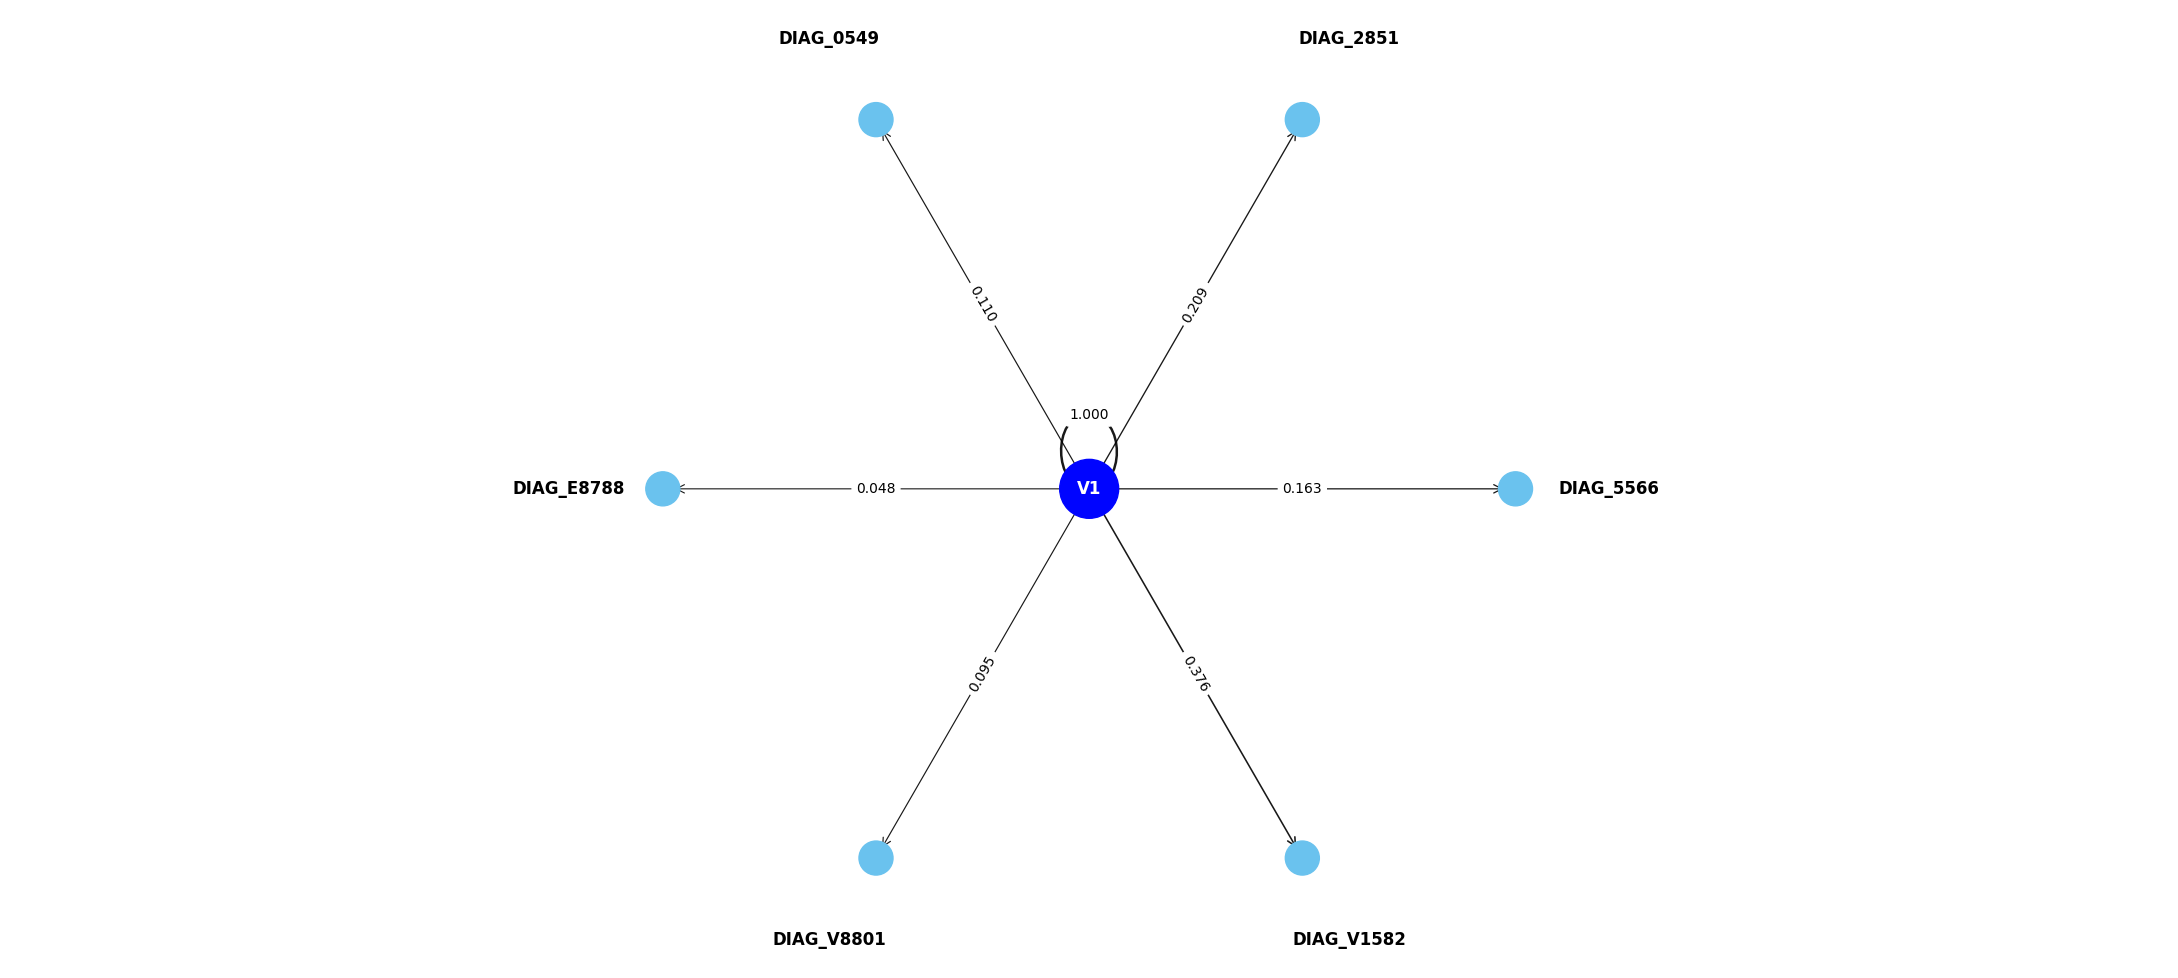

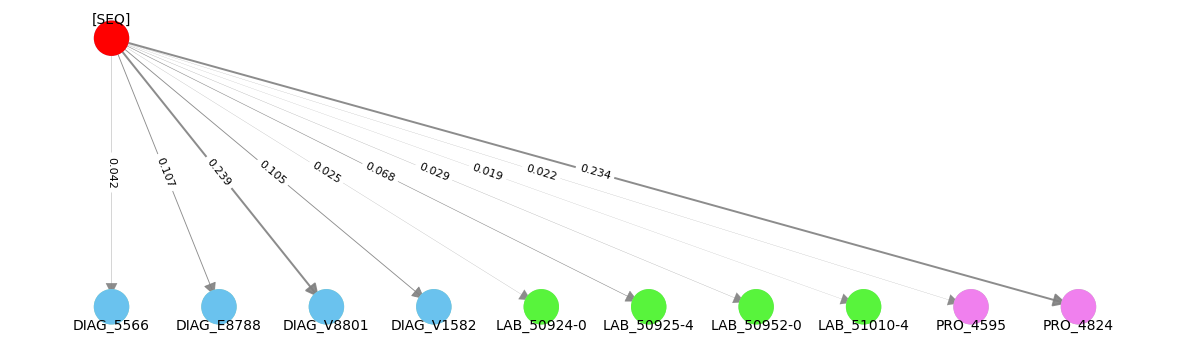

No group code!


Next admission diseases:
Fluid and electrolyte disorders
Other lower respiratory disease


In [22]:
viser.visualize(input_ids, token_types, adm_index, age_ids, diag_code_group_dicts, labels, 
                sample_idx = 12)